In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# Open the netCDF file
nc_file = nc.Dataset('ex4k.nc', 'r')
# Get the number of records in the file
num_records = nc_file.dimensions['idx'].size

In [3]:
# Define the index to split the file
split_index = int(num_records*0.8)  # Change this to your desired split index

In [4]:
# Create two separate netCDF files
part1_file = nc.Dataset('part1.nc', 'w', format='NETCDF4')
part2_file = nc.Dataset('part2.nc', 'w', format='NETCDF4')


In [5]:
# Copy global attributes from the original file
part1_file.setncatts(nc_file.__dict__)
part2_file.setncatts(nc_file.__dict__)

In [6]:
# Create dimensions in the new files 
for name, dimension in nc_file.dimensions.items():
    if name == 'idx':
        part1_file.createDimension(name, split_index)
        part2_file.createDimension(name, num_records - split_index)
    else:
        part1_file.createDimension(name, len(dimension))
        part2_file.createDimension(name, len(dimension))


In [7]:
# Copy variables from the original file to the new files
for name, variable in nc_file.variables.items():
    if name in ['ela', 'topg', 'gfp','time']:
        # Create variables in the new files
        var1 = part1_file.createVariable(name, variable.dtype, variable.dimensions)
        var2 = part2_file.createVariable(name, variable.dtype, variable.dimensions)

        # Copy variable attributes
        var1.setncatts(variable.__dict__)
        var2.setncatts(variable.__dict__)

        # Copy variable data based on the split index
        var1[:] = variable[:split_index]
        var2[:] = variable[split_index:]


In [8]:
# Close the files
nc_file.close()
part1_file.close()
part2_file.close()

In [ ]:
## 

## Test Model

In [2]:
import tensorflow as tf
import os

2023-06-27 14:00:05.954221: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 14:00:06.001378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-27 14:00:06.001389: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [33]:
# load test data
test_path='fordle/AllTopo4k_N/test/ALP06_A78_C0/ex.nc'
train_path='fordle/AllTopo4k_N/train/ALP00_A78_C0/ex.nc'
ds = nc.Dataset(test_path)
topg=ds['topg']
topg=np.array(topg)
ela=ds['ela']
ela=np.array(ela)
gfp=ds['gfp']
gfp=np.array(gfp)
time=ds['time']
time=np.array(time)


In [34]:
#load models
dirpath='result_allT_std/'
iceflow_model = tf.keras.models.load_model(
            os.path.join(dirpath, "model.h5")
        )

In [35]:
def predict(topg_,ela_,time_):
    PAD = [[0, 0], [0, 0]]
    X_ = tf.concat([
                            tf.expand_dims(
                                tf.expand_dims(
                                    tf.pad(topg_/3450, PAD, "CONSTANT"), axis=0
                                ),
                                axis=-1,
                            ),
                            tf.expand_dims(
                                tf.expand_dims(
                                    tf.pad(ela_/310, PAD, "CONSTANT"), axis=0
                                ),
                                axis=-1,
                            ),
                            tf.expand_dims(
                                tf.expand_dims(
                                    tf.pad(time_/4, PAD, "CONSTANT"), axis=0
                                ),
                                axis=-1,
                            ),
                        ],
                        axis=-1,
                    )
    return tf.squeeze(iceflow_model(X_))*2500

In [36]:
idx=1
Pred = predict(topg[idx],ela[0],time[0]).numpy()

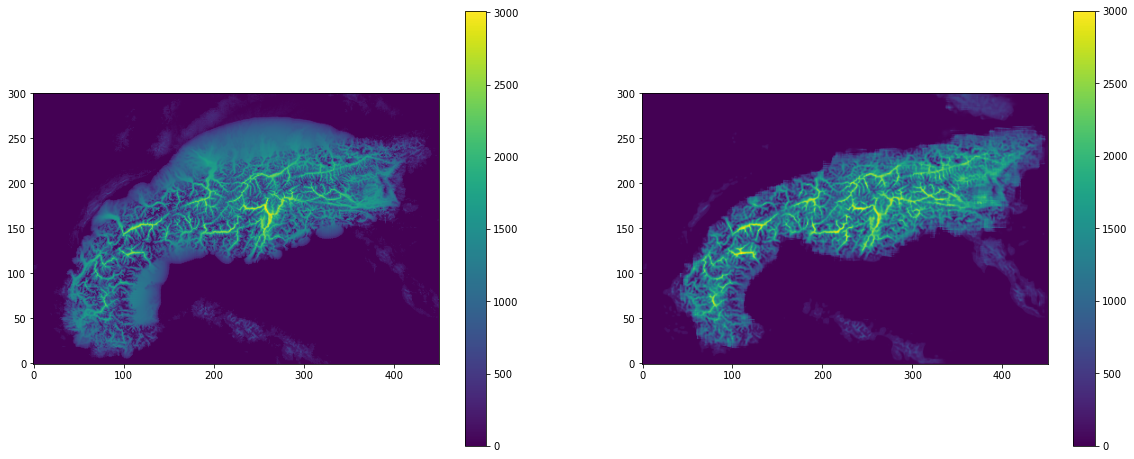

In [38]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Display the first image with a colorbar
im1 = ax1.imshow(gfp[idx])
fig.colorbar(im1, ax=ax1)

# Display the second image with a colorbar
im2 = ax2.imshow(np.clip(Pred,a_min=0,a_max=3000))
fig.colorbar(im2, ax=ax2)

# Invert the y-axis
ax1.invert_yaxis()
ax2.invert_yaxis()


plt.show()
